# Housekeeping

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Data Gathering

In [36]:
timespan = 1000

def get_data():
    BRENT = yf.download("BZ=F", auto_adjust=True, period = 'max')["Close"]
    WTI = yf.download("CL=F", auto_adjust=True, period = 'max')["Close"]

    df = pd.concat([BRENT, WTI], axis=1)
    df.columns = ['BRENT', 'WTI']

    df = df.iloc[-timespan:]  
    print(df.head())
    return df.dropna()

def plot_price_data(df):
    plt.figure(figsize=(8,5))
    plt.plot(df['BRENT'], label = 'BRENT Close')
    plt.plot(df['WTI'], label = 'WTI Close')
    plt.title('BRENT vs WTI Close prices')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.legend()
    plt.grid(True)
    plt.show()
    return df

# Checking Probability and Suitability for Modelling

In [37]:
from statsmodels.tsa.stattools import adfuller

def check_suitability(series1, series2, corr_thresh=0.8, adf_p_thresh=0.05):
    """
    Check whether two series are suitable for arbitrage:
    - Pearson correlation > corr_thresh
    - Spread (series1 - series2) is stationary (ADF p-value < adf_p_thresh)
    """
    correlation = series1.corr(series2)
    print(f"Pearson correlation: {correlation:.4f}")
    if correlation < corr_thresh:
        print(f"→ CORR below {corr_thresh}: skip strategy.")
        return False

    spread = series1 - series2
    adf_p = adfuller(spread)[1]
    print(f"ADF test p-value (spread): {adf_p:.4f}")
    if adf_p >= adf_p_thresh:
        print(f"→ ADF p ≥ {adf_p_thresh}: non‑stationary spread. Skip.")
        return False

    print("Pair suitable. Proceeding.")
    return True

# Calculating Spread and Zscore

In [38]:
def calculate_spread_zscore(df):
    df['spread'] = df['BRENT'] - df['WTI']
    df['spread_mean'] = df['spread'].rolling(window=30).mean()
    df['spread_std'] = df['spread'].rolling(window=30).std()
    df['spread_zscore'] = (df['spread'] - df['spread_mean']) / df['spread_std']

    # Plotting the spread
    plt.figure(figsize=(8,5))
    plt.plot(df['spread'], label='BRENT-WTI Spread')
    plt.plot(df['spread_mean'], label='30-Day Moving Average')  # fixed label to match window size
    plt.title('BRENT-WTI Spread and Moving Average')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plotting the z-score
    plt.figure(figsize=(8,5))
    plt.plot(df['spread_zscore'], label='Z Score', color='blue')  # fixed key name
    plt.axhline(-1, color='red', linestyle='--', label='Short Brent, Long WTI')
    plt.axhline(1, color='green', linestyle='--', label='Long Brent, Short WTI')
    plt.title('BRENT-WTI Z-Score')
    plt.xlabel('Date')
    plt.ylabel('Z-Score')
    plt.legend()
    plt.grid(True)
    plt.show()

    return df

# Generating Buy/Sell Signals & Calculating Returns

In [39]:

#Buy and Sell Signals

def define_signals(df):
    df['position'] = 0
    df.loc[df['spread_zscore'] > 1, 'position'] = -1
    df.loc[df['spread_zscore'] < -1, 'position'] = 1
    df.loc[(df['spread_zscore'] > -0.5) & (df['spread_zscore'] < 0.5), 'position'] = 0
    return df

def explicit_positions(df):
    df['BRENT_position'] = 0
    df['WTI_position'] = 0
    df.loc[df['position'] == 1, ['BRENT_position', 'WTI_position']] = [1, -1]
    df.loc[df['position'] == -1, ['BRENT_position', 'WTI_position']] = [-1, 1]
    return df

def calculate_returns(df):
    df['BRENT_returns'] = df['BRENT'].pct_change()
    df['WTI_returns'] = df['WTI'].pct_change()

    df['strategy_returns_explicit'] = (
        df['BRENT_position'].shift(1) * df['BRENT_returns'] +
        df['WTI_position'].shift(1) * df['WTI_returns']
    )

    df['strategy_cumulative_explicit'] = (1 + df['strategy_returns_explicit'].fillna(0)).cumprod()

    plt.figure(figsize=(10, 6))
    plt.plot(df['strategy_cumulative_explicit'], label='Strategy Cumulative Return', color='blue')
    plt.title('Cumulative Returns of Brent vs WTI Arbitrage Strategy')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

    return df

    

# Running the Code

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


                BRENT        WTI
Date                            
2021-07-29  76.050003  73.620003
2021-07-30  76.330002  73.949997
2021-08-02  72.889999  71.260002
2021-08-03  72.410004  70.559998
2021-08-04  70.379997  68.150002


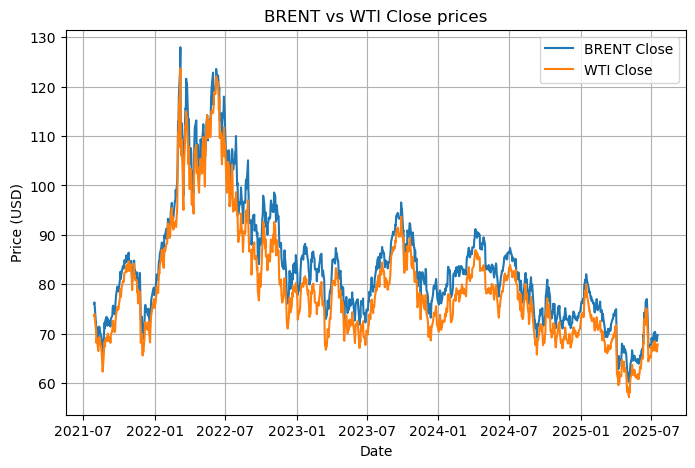

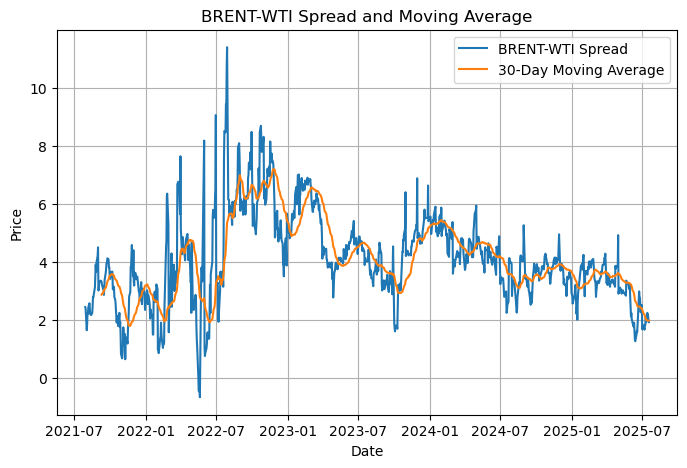

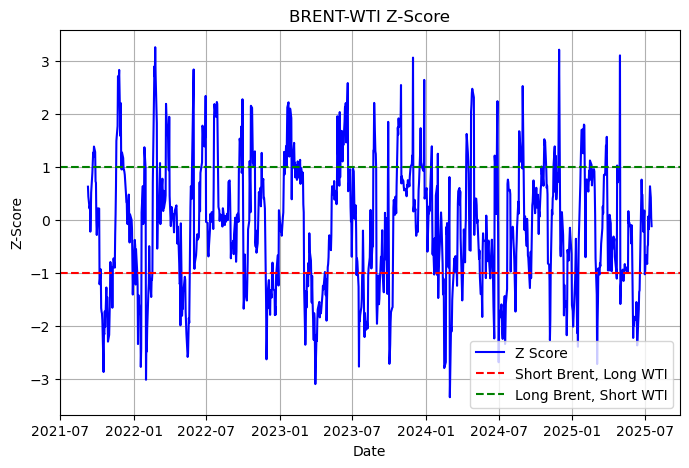

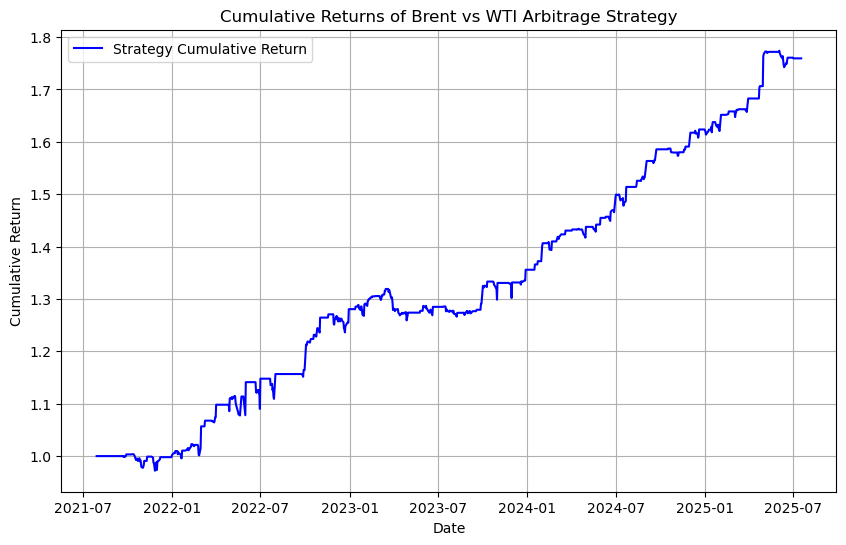

BRENT WTI Arbitrage Strategy P&L: 75.94%
BRENT Price Change: -8.32%
WTI Price Change: -7.89%


In [40]:
def performance_summary(df):
    
    BRENT_Return = (df['BRENT_returns'].dropna() + 1).prod() - 1
    WTI_Return = (df['WTI_returns'].dropna() + 1).prod() - 1

    pnl_pct = (df['strategy_cumulative_explicit'].iloc[-1] - 1) * 100
    mean_ret = df['strategy_returns_explicit'].mean()
    std_ret = df['strategy_returns_explicit'].std()

    print(f"BRENT WTI Arbitrage Strategy P&L: {pnl_pct:.2f}%")
    print(f"BRENT Price Change: {BRENT_Return * 100:.2f}%")
    print(f"WTI Price Change: {WTI_Return * 100:.2f}%")

def main():
    df = get_data()
    
    #if not check_suitability(df['BRENT'], df['WTI']):
     #   print("Aborting: unsuitable pair.")
       # return
    
    df = plot_price_data(df)         
    df = calculate_spread_zscore(df)
    df = define_signals(df)
    df = explicit_positions(df)
    df = calculate_returns(df)
    df = performance_summary(df)

main()